In [ ]:
# =============================================================================
# STEP 0: IMPORTS & SETUP
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.feature_selection import RFE, mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [ ]:
# =============================================================================
# STEP 1: COMPREHENSIVE DATA EXPLORATION
# =============================================================================

df = pd.read_excel('/content/IBM HR Dataset.xlsx')
print("=" * 60)
print("STEP 1: COMPREHENSIVE DATA EXPLORATION")
print("=" * 60)

# 1.1 Basic Dataset Info
print("1.1 DATASET OVERVIEW:")
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# 1.2 Target Variable Analysis
print("\n1.2 TARGET VARIABLE ANALYSIS:")
attrition_counts = df['Attrition'].value_counts()
attrition_percent = df['Attrition'].value_counts(normalize=True) * 100
print("Attrition Distribution:")
for status, (count, percent) in enumerate(zip(attrition_counts, attrition_percent)):
    print(f"  {attrition_counts.index[status]}: {count} ({percent:.1f}%)")

print(f"🚨 CLASS IMBALANCE DETECTED: {attrition_percent['Yes']:.1f}% positive class")

# 1.3 Data Types & Basic Stats
print("\n1.3 DATA TYPES & BASIC STATISTICS:")
print(df.info())

# 1.4 Check for Constant Columns
print("\n1.4 CONSTANT/VARIANCE CHECK:")
constant_cols = []
for col in df.columns:
    if df[col].nunique() == 1:
        constant_cols.append(col)
print(f"Constant columns: {constant_cols}")

# 1.5 Outlier Detection
print("\n1.5 OUTLIER DETECTION (Numerical Features):")
numerical_cols = df.select_dtypes(include=[np.number]).columns
outlier_summary = []
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    if outliers > 0:
        outlier_summary.append((col, outliers, f"{(outliers/len(df)*100):.1f}%"))

if outlier_summary:
    print("Columns with outliers:")
    for col, count, percent in outlier_summary:
        print(f"  {col}: {count} outliers ({percent})")
else:
    print("No significant outliers detected")

print("\n" + "=" * 60)
print("STEP 1 COMPLETE")
print("=" * 60)

STEP 1: COMPREHENSIVE DATA EXPLORATION
1.1 DATASET OVERVIEW:
Dataset shape: (1470, 35)
Missing values: 0

1.2 TARGET VARIABLE ANALYSIS:
Attrition Distribution:
  No: 1233 (83.9%)
  Yes: 237 (16.1%)
🚨 CLASS IMBALANCE DETECTED: 16.1% positive class

1.3 DATA TYPES & BASIC STATISTICS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNum

In [ ]:
# =============================================================================
# STEP 2: ADVANCED FEATURE ENGINEERING WITH ECONOMIC DATA
# =============================================================================

print("=" * 60)
print("STEP 2: ADVANCED FEATURE ENGINEERING")
print("=" * 60)

# Create a copy for feature engineering
df_engineered = df.copy()

# 2.1 Economic Data Integration
print("2.1 ECONOMIC DATA INTEGRATION...")

# Unemployment rates mapping (by JobRole and Gender)
unemployment_rates = {
    # Male unemployment rates
    ('Sales Executive', 'Male'): 4.7, ('Sales Representative', 'Male'): 4.7,
    ('Research Scientist', 'Male'): 1.2, ('Laboratory Technician', 'Male'): 4.9,
    ('Manufacturing Director', 'Male'): 1.6, ('Healthcare Representative', 'Male'): 4.8,
    ('Research Director', 'Male'): 1.6, ('Human Resources', 'Male'): 3.0, ('Manager', 'Male'): 1.6,
    # Female unemployment rates
    ('Sales Executive', 'Female'): 3.0, ('Sales Representative', 'Female'): 3.0,
    ('Research Scientist', 'Female'): 5.2, ('Laboratory Technician', 'Female'): 1.4,
    ('Manufacturing Director', 'Female'): 2.7, ('Healthcare Representative', 'Female'): 1.0,
    ('Research Director', 'Female'): 2.7, ('Human Resources', 'Female'): 2.8, ('Manager', 'Female'): 2.7
}

# Add economic features
df_engineered['UnemploymentRate'] = df_engineered.apply(
    lambda row: unemployment_rates.get((row['JobRole'], row['Gender']), 3.0), axis=1
)
df_engineered['InflationRate'] = 1.9  # Ontario annual inflation

# 2.2 Advanced Feature Engineering
print("2.2 ADVANCED FEATURE ENGINEERING...")

# Economic features
df_engineered['RealMonthlyIncome'] = df_engineered['MonthlyIncome'] / (1 + df_engineered['InflationRate']/100)
df_engineered['JobSecurityScore'] = 10 - df_engineered['UnemploymentRate']
df_engineered['IncomeToMarketRatio'] = df_engineered['MonthlyIncome'] / df_engineered.groupby('JobRole')['MonthlyIncome'].transform('median')

# Work condition features
df_engineered['OverTimeNum'] = df_engineered['OverTime'].map({'Yes': 1, 'No': 0})
travel_mapping = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
df_engineered['BusinessTravelNum'] = df_engineered['BusinessTravel'].map(travel_mapping)
df_engineered['IsSingle'] = df_engineered['MaritalStatus'].map({'Single': 1, 'Married': 0, 'Divorced': 0})

# Career progression features
df_engineered['TenureRatio'] = df_engineered['YearsAtCompany'] / (df_engineered['TotalWorkingYears'] + 1)
df_engineered['PromotionStagnation'] = df_engineered['YearsSinceLastPromotion']
df_engineered['RoleTenureRatio'] = df_engineered['YearsInCurrentRole'] / (df_engineered['YearsAtCompany'] + 1)
df_engineered['CareerGrowthRate'] = df_engineered['JobLevel'] / (df_engineered['TotalWorkingYears'] + 1)

# Interaction features
df_engineered['Overtime_Income_Interaction'] = df_engineered['OverTimeNum'] * df_engineered['RealMonthlyIncome']
df_engineered['Travel_Single_Interaction'] = df_engineered['BusinessTravelNum'] * df_engineered['IsSingle']

print(f"✅ Added {12} new engineered features")
print(f"New dataset shape: {df_engineered.shape}")

# 2.3 Remove unnecessary columns
columns_to_drop = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber', 'MonthlyIncome']
df_engineered = df_engineered.drop(columns=columns_to_drop, errors='ignore')

print("\n" + "=" * 60)
print("STEP 2 COMPLETE")
print("=" * 60)

STEP 2: ADVANCED FEATURE ENGINEERING
2.1 ECONOMIC DATA INTEGRATION...
2.2 ADVANCED FEATURE ENGINEERING...
✅ Added 12 new engineered features
New dataset shape: (1470, 49)

STEP 2 COMPLETE


In [ ]:
# =============================================================================
# STEP 3: COMPREHENSIVE DATA PREPROCESSING
# =============================================================================

print("=" * 60)
print("STEP 3: COMPREHENSIVE DATA PREPROCESSING")
print("=" * 60)

# 3.1 Handle Categorical Variables
print("3.1 CATEGORICAL VARIABLE ENCODING...")

# Identify categorical columns
categorical_cols = df_engineered.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'Attrition']

print(f"Categorical columns to encode: {categorical_cols}")

# Use proper encoding strategies
df_processed = df_engineered.copy()
label_encoders = {}

for col in categorical_cols:
    # For low-cardinality features, use label encoding
    if df_processed[col].nunique() <= 10:
        le = LabelEncoder()
        df_processed[col + '_Encoded'] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"  Label encoded {col}: {df_processed[col].nunique()} categories")
    else:
        # For high-cardinality, consider frequency encoding or target encoding
        print(f"  ⚠️  High cardinality: {col} has {df_processed[col].nunique()} categories")

# 3.2 Prepare Features and Target
print("\n3.2 PREPARING FEATURES AND TARGET...")

# Select all potential features (we'll do proper feature selection later)
all_features = [col for col in df_processed.columns
                if col not in ['Attrition'] and not col.endswith('_Original')]

# Separate features and target
X = df_processed[all_features]
y = df_processed['Attrition'].map({'Yes': 1, 'No': 0})

print(f"Initial feature set: {X.shape[1]} features")
print(f"Target distribution: {y.value_counts().to_dict()}")

# 3.3 Train-Test Split with Stratification
print("\n3.3 TRAIN-TEST SPLIT...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain same class distribution
)

print(f"Training set: {X_train.shape} ({(len(X_train)/len(X)*100):.1f}%)")
print(f"Test set: {X_test.shape} ({(len(X_test)/len(X)*100):.1f}%)")
print(f"Training attrition rate: {(y_train.sum() / len(y_train) * 100):.2f}%")
print(f"Test attrition rate: {(y_test.sum() / len(y_test) * 100):.2f}%")

# 3.4 Feature Scaling
print("\n3.4 FEATURE SCALING...")

# Identify numerical columns for scaling
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Remove binary columns from scaling
binary_cols = [col for col in numerical_cols if X[col].nunique() == 2]
numerical_to_scale = [col for col in numerical_cols if col not in binary_cols]

print(f"Numerical features to scale: {len(numerical_to_scale)}")
print(f"Binary features (not scaled): {len(binary_cols)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_to_scale] = scaler.fit_transform(X_train[numerical_to_scale])
X_test_scaled[numerical_to_scale] = scaler.transform(X_test[numerical_to_scale])

print("✅ Feature scaling completed")

print("\n" + "=" * 60)
print("STEP 3 COMPLETE")
print("=" * 60)

STEP 3: COMPREHENSIVE DATA PREPROCESSING
3.1 CATEGORICAL VARIABLE ENCODING...
Categorical columns to encode: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
  Label encoded BusinessTravel: 3 categories
  Label encoded Department: 3 categories
  Label encoded EducationField: 6 categories
  Label encoded Gender: 2 categories
  Label encoded JobRole: 9 categories
  Label encoded MaritalStatus: 3 categories
  Label encoded OverTime: 2 categories

3.2 PREPARING FEATURES AND TARGET...
Initial feature set: 50 features
Target distribution: {0: 1233, 1: 237}

3.3 TRAIN-TEST SPLIT...
Training set: (1176, 50) (80.0%)
Test set: (294, 50) (20.0%)
Training attrition rate: 16.16%
Test attrition rate: 15.99%

3.4 FEATURE SCALING...
Numerical features to scale: 38
Binary features (not scaled): 5
✅ Feature scaling completed

STEP 3 COMPLETE


In [ ]:
# =============================================================================
# STEP 4: ADVANCED FEATURE SELECTION (FIXED)
# =============================================================================

print("=" * 60)
print("STEP 4: ADVANCED FEATURE SELECTION")
print("=" * 60)

# 4.1 First, let's check what's actually in our datasets
print("4.1 DATA TYPE CHECK...")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_train_scaled dtypes:\n{X_train_scaled.dtypes.value_counts()}")

# Identify non-numeric columns
non_numeric_cols = X_train_scaled.select_dtypes(include=['object']).columns.tolist()
print(f"Non-numeric columns: {non_numeric_cols}")

# 4.2 Properly encode ALL categorical variables
print("\n4.2 PROPER CATEGORICAL ENCODING...")

# Create properly encoded dataset
X_encoded = X_train.copy()

# Encode all remaining categorical variables
for col in non_numeric_cols:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col + '_Encoded'] = le.fit_transform(X_encoded[col].astype(str))
        # Remove original column
        X_encoded = X_encoded.drop(columns=[col])
        print(f"  Encoded {col}")

# Apply same encoding to test set
X_test_encoded = X_test.copy()
for col in non_numeric_cols:
    if col in X_test_encoded.columns:
        le = LabelEncoder()
        # Handle unseen categories in test set
        unique_train = set(X_train[col].astype(str).unique())
        unique_test = set(X_test[col].astype(str).unique())
        unseen_categories = unique_test - unique_train

        if unseen_categories:
            print(f"  ⚠️  Unseen categories in test set for {col}: {unseen_categories}")
            # For unseen categories, map to most frequent category
            X_test_encoded[col] = X_test_encoded[col].astype(str)
            X_test_encoded.loc[~X_test_encoded[col].isin(unique_train), col] = X_train[col].mode()[0]

        X_test_encoded[col + '_Encoded'] = le.fit_transform(X_test_encoded[col].astype(str))
        X_test_encoded = X_test_encoded.drop(columns=[col])

# 4.3 Scale the properly encoded data
print("\n4.3 SCALING PROPERLY ENCODED DATA...")

# Identify numerical columns for scaling (now all should be numeric)
numerical_cols_encoded = X_encoded.select_dtypes(include=[np.number]).columns.tolist()
binary_cols_encoded = [col for col in numerical_cols_encoded if X_encoded[col].nunique() == 2]
numerical_to_scale_encoded = [col for col in numerical_cols_encoded if col not in binary_cols_encoded]

print(f"Numerical features to scale: {len(numerical_to_scale_encoded)}")
print(f"Binary features (not scaled): {len(binary_cols_encoded)}")

# Scale features
scaler_fixed = StandardScaler()
X_train_final_scaled = X_encoded.copy()
X_test_final_scaled = X_test_encoded.copy()

X_train_final_scaled[numerical_to_scale_encoded] = scaler_fixed.fit_transform(X_encoded[numerical_to_scale_encoded])
X_test_final_scaled[numerical_to_scale_encoded] = scaler_fixed.transform(X_test_encoded[numerical_to_scale_encoded])

print(f"Final training set shape: {X_train_final_scaled.shape}")
print(f"Final test set shape: {X_test_final_scaled.shape}")

# 4.4 Multicollinearity Check (Now it should work)
print("\n4.4 MULTICOLLINEARITY ANALYSIS...")

# Calculate correlation matrix
correlation_matrix = X_train_final_scaled.corr()

# Find highly correlated features (|correlation| > 0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("🚨 Highly correlated feature pairs (|corr| > 0.8):")
    for feat1, feat2, corr in high_corr_pairs[:10]:  # Show top 10
        print(f"  {feat1} ↔ {feat2}: {corr:.3f}")

    # Remove one from each highly correlated pair
    features_to_remove = set()
    for feat1, feat2, corr in high_corr_pairs:
        # Keep the one with higher variance (more information)
        var1 = X_train_final_scaled[feat1].var()
        var2 = X_train_final_scaled[feat2].var()
        if var1 >= var2:
            features_to_remove.add(feat2)
        else:
            features_to_remove.add(feat1)

    print(f"Removing {len(features_to_remove)} features due to high correlation")
    X_train_final_scaled = X_train_final_scaled.drop(columns=list(features_to_remove))
    X_test_final_scaled = X_test_final_scaled.drop(columns=list(features_to_remove))
else:
    print("✅ No severe multicollinearity detected")

# 4.5 Mutual Information with Target
print("\n4.5 FEATURE IMPORTANCE (MUTUAL INFORMATION)...")

# Calculate mutual information
mi_scores = mutual_info_classif(X_train_final_scaled, y_train, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X_train_final_scaled.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("Top 15 features by Mutual Information:")
print(mi_df.head(15).to_string(index=False))

# 4.6 Recursive Feature Elimination
print("\n4.6 RECURSIVE FEATURE ELIMINATION...")

# Use a simple model for RFE
rfe_selector = RFE(
    estimator=LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    n_features_to_select=min(20, X_train_final_scaled.shape[1]),  # Select top 20 features or all if less
    step=1
)

rfe_selector.fit(X_train_final_scaled, y_train)
selected_features_rfe = X_train_final_scaled.columns[rfe_selector.support_]

print(f"RFE selected {len(selected_features_rfe)} features:")
for i, feature in enumerate(selected_features_rfe, 1):
    print(f"  {i:2d}. {feature}")

# 4.7 Final Feature Selection
print("\n4.7 FINAL FEATURE SELECTION...")

# Combine selection methods: Take features that appear in top of MI or RFE
top_mi_features = mi_df.head(25)['Feature'].tolist()
final_features = list(set(top_mi_features) | set(selected_features_rfe))

print(f"Final selected features: {len(final_features)}")

# Create final datasets
X_train_final = X_train_final_scaled[final_features]
X_test_final = X_test_final_scaled[final_features]

print(f"\nFinal training set: {X_train_final.shape}")
print(f"Final test set: {X_test_final.shape}")

# Verify no missing or infinite values
print(f"\nData quality check:")
print(f"Missing values in train: {X_train_final.isnull().sum().sum()}")
print(f"Missing values in test: {X_test_final.isnull().sum().sum()}")
print(f"Infinite values in train: {np.isinf(X_train_final.values).sum()}")
print(f"Infinite values in test: {np.isinf(X_test_final.values).sum()}")

print("\n" + "=" * 60)
print("STEP 4 COMPLETE")
print("=" * 60)

STEP 4: ADVANCED FEATURE SELECTION
4.1 DATA TYPE CHECK...
X_train_scaled shape: (1176, 50)
X_train_scaled dtypes:
float64    38
object      7
int64       5
Name: count, dtype: int64
Non-numeric columns: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

4.2 PROPER CATEGORICAL ENCODING...
  Encoded BusinessTravel
  Encoded Department
  Encoded EducationField
  Encoded Gender
  Encoded JobRole
  Encoded MaritalStatus
  Encoded OverTime

4.3 SCALING PROPERLY ENCODED DATA...
Numerical features to scale: 38
Binary features (not scaled): 5
Final training set shape: (1176, 43)
Final test set shape: (294, 43)

4.4 MULTICOLLINEARITY ANALYSIS...
🚨 Highly correlated feature pairs (|corr| > 0.8):
  JobLevel ↔ RealMonthlyIncome: 0.947
  YearsSinceLastPromotion ↔ PromotionStagnation: 1.000
  UnemploymentRate ↔ JobSecurityScore: -1.000
  OverTimeNum ↔ OverTime_Encoded: 1.000
  IsSingle ↔ Travel_Single_Interaction: 0.855
  IsSingle ↔ MaritalStatus_Enc

In [ ]:
# =============================================================================
# STEP 5: CLASS IMBALANCE HANDLING & BASELINE MODELS
# =============================================================================

print("=" * 60)
print("STEP 5: CLASS IMBALANCE HANDLING & BASELINE MODELS")
print("=" * 60)

# 5.1 Evaluate Class Imbalance Strategies
print("5.1 CLASS IMBALANCE STRATEGY EVALUATION...")

# Define comprehensive evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Comprehensive model evaluation with multiple metrics"""
    try:
        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = (y_pred == y_test).mean()
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        auc_pr = average_precision_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)

        # Confusion matrix details
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        return {
            'model': model,
            'accuracy': accuracy,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr,  # Better for imbalanced data
            'f1_score': f1,
            'recall': recall,
            'precision': precision,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'confusion_matrix': cm
        }
    except Exception as e:
        print(f"  Error evaluating {model_name}: {e}")
        return None

# 5.2 Compare Different Imbalance Handling Strategies
print("\n5.2 COMPARING IMBALANCE HANDLING STRATEGIES...")

strategies = {
    'No Handling': LogisticRegression(random_state=42, max_iter=1000),
    'Class Weight': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'SMOTE': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', LogisticRegression(random_state=42, max_iter=1000))
    ])
}

strategy_results = {}

print("Imbalance Strategy Comparison:")
print("-" * 80)
for strategy_name, model in strategies.items():
    print(f"\n{strategy_name}:")
    results = evaluate_model(model, X_train_final, X_test_final, y_train, y_test, strategy_name)
    if results:
        strategy_results[strategy_name] = results

        print(f"  Accuracy:  {results['accuracy']:.4f}")
        print(f"  AUC-ROC:   {results['auc_roc']:.4f}")
        print(f"  AUC-PR:    {results['auc_pr']:.4f} ← Most important for imbalance")
        print(f"  F1-Score:  {results['f1_score']:.4f}")
        print(f"  Recall:    {results['recall']:.4f} (Ability to find leavers)")
        print(f"  Precision: {results['precision']:.4f} (Accuracy when predicting leavers)")

# 5.3 Determine Best Strategy
print("\n5.3 DETERMINING BEST IMBALANCE STRATEGY...")

if strategy_results:
    best_strategy = max(strategy_results.items(), key=lambda x: x[1]['auc_pr'])[0]
    best_auc_pr = strategy_results[best_strategy]['auc_pr']
    print(f"🎯 BEST STRATEGY: {best_strategy} (AUC-PR: {best_auc_pr:.4f})")

    # Show why this is best
    print(f"\nWhy {best_strategy} is best:")
    for strategy, results in strategy_results.items():
        improvement = results['auc_pr'] - strategy_results['No Handling']['auc_pr']
        print(f"  {strategy}: AUC-PR = {results['auc_pr']:.4f} ({improvement:+.4f} improvement)")
else:
    print("❌ No strategies successfully evaluated")
    best_strategy = 'Class Weight'  # Fallback

# 5.4 Baseline Models with Best Strategy
print(f"\n5.4 BASELINE MODELS USING {best_strategy.upper()} STRATEGY...")

# Define baseline models with appropriate imbalance handling
if best_strategy == 'Class Weight':
    baseline_models = {
        'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
elif best_strategy == 'SMOTE':
    baseline_models = {
        'Logistic Regression': Pipeline([('smote', SMOTE(random_state=42)),
                                        ('model', LogisticRegression(random_state=42, max_iter=1000))]),
        'Random Forest': Pipeline([('smote', SMOTE(random_state=42)),
                                  ('model', RandomForestClassifier(random_state=42))]),
        'Gradient Boosting': Pipeline([('smote', SMOTE(random_state=42)),
                                      ('model', GradientBoostingClassifier(random_state=42))])
    }
else:  # No Handling
    baseline_models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

baseline_results = {}

print(f"\nBaseline Models Performance:")
print("-" * 70)
for model_name, model in baseline_models.items():
    print(f"\n{model_name}:")
    results = evaluate_model(model, X_train_final, X_test_final, y_train, y_test, model_name)
    if results:
        baseline_results[model_name] = results

        print(f"  Accuracy:  {results['accuracy']:.4f}")
        print(f"  AUC-ROC:   {results['auc_roc']:.4f}")
        print(f"  AUC-PR:    {results['auc_pr']:.4f}")
        print(f"  F1-Score:  {results['f1_score']:.4f}")
        print(f"  Recall:    {results['recall']:.4f}")
        print(f"  Precision: {results['precision']:.4f}")

        # Show confusion matrix
        cm = results['confusion_matrix']
        print(f"  Confusion Matrix:")
        print(f"    True Negatives:  {cm[0,0]} | False Positives: {cm[0,1]}")
        print(f"    False Negatives: {cm[1,0]} | True Positives:  {cm[1,1]}")

# 5.5 Cross-Validation Performance
print("\n5.5 CROSS-VALIDATION PERFORMANCE (AUC-PR)...")

# Use stratified K-fold for reliable evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("5-fold Cross-validation scores:")
cv_results = {}
for model_name, model in baseline_models.items():
    try:
        cv_scores = cross_val_score(model, X_train_final, y_train, scoring='average_precision', cv=cv, n_jobs=-1)
        cv_results[model_name] = cv_scores
        print(f"  {model_name}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    except Exception as e:
        print(f"  {model_name}: CV failed - {e}")

# 5.6 Identify Best Baseline Model
print("\n5.6 BEST BASELINE MODEL IDENTIFICATION...")

if baseline_results:
    best_baseline = max(baseline_results.items(), key=lambda x: x[1]['auc_pr'])[0]
    best_baseline_score = baseline_results[best_baseline]['auc_pr']

    print(f"🏆 BEST BASELINE MODEL: {best_baseline}")
    print(f"   Test AUC-PR: {best_baseline_score:.4f}")
    print(f"   Key metrics:")
    best_results = baseline_results[best_baseline]
    print(f"     - Recall:    {best_results['recall']:.4f} (finds {best_results['recall']*100:.1f}% of actual leavers)")
    print(f"     - Precision: {best_results['precision']:.4f} ({best_results['precision']*100:.1f}% of leaver predictions are correct)")
    print(f"     - F1-Score:  {best_results['f1_score']:.4f} (balance between precision and recall)")

print("\n" + "=" * 60)
print("STEP 5 COMPLETE")
print("=" * 60)

# Save the best model for later use
if baseline_results:
    best_baseline_model = baseline_results[best_baseline]['model']
    print(f"\n✅ Best model '{best_baseline}' saved for further analysis")

STEP 5: CLASS IMBALANCE HANDLING & BASELINE MODELS
5.1 CLASS IMBALANCE STRATEGY EVALUATION...

5.2 COMPARING IMBALANCE HANDLING STRATEGIES...
Imbalance Strategy Comparison:
--------------------------------------------------------------------------------

No Handling:
  Accuracy:  0.8605
  AUC-ROC:   0.7962
  AUC-PR:    0.5424 ← Most important for imbalance
  F1-Score:  0.4225
  Recall:    0.3191 (Ability to find leavers)
  Precision: 0.6250 (Accuracy when predicting leavers)

Class Weight:
  Accuracy:  0.7585
  AUC-ROC:   0.7970
  AUC-PR:    0.5416 ← Most important for imbalance
  F1-Score:  0.4662
  Recall:    0.6596 (Ability to find leavers)
  Precision: 0.3605 (Accuracy when predicting leavers)

SMOTE:
  Accuracy:  0.7245
  AUC-ROC:   0.7270
  AUC-PR:    0.4547 ← Most important for imbalance
  F1-Score:  0.4173
  Recall:    0.6170 (Ability to find leavers)
  Precision: 0.3152 (Accuracy when predicting leavers)

5.3 DETERMINING BEST IMBALANCE STRATEGY...
🎯 BEST STRATEGY: No Handling 

STEP 6: MODEL INTERPRETATION & BUSINESS INSIGHTS
6.1 FEATURE IMPORTANCE ANALYSIS:
Top 20 Most Influential Features:
                 Feature  Coefficient  Abs_Coefficient  Odds_Ratio
             OverTimeNum     1.680288         1.680288    5.367100
      NumCompaniesWorked     0.582777         0.582777    1.791006
 YearsSinceLastPromotion     0.502770         0.502770    1.653295
         RoleTenureRatio    -0.498261         0.498261    0.607586
       BusinessTravelNum     0.491668         0.491668    1.635041
       RealMonthlyIncome    -0.487837         0.487837    0.613953
 EnvironmentSatisfaction    -0.470316         0.470316    0.624805
         JobSatisfaction    -0.407120         0.407120    0.665564
          JobInvolvement    -0.393905         0.393905    0.674418
      YearsInCurrentRole     0.361959         0.361959    1.436140
        CareerGrowthRate     0.348591         0.348591    1.417069
        DistanceFromHome     0.347190         0.347190    1.415085
      Departm

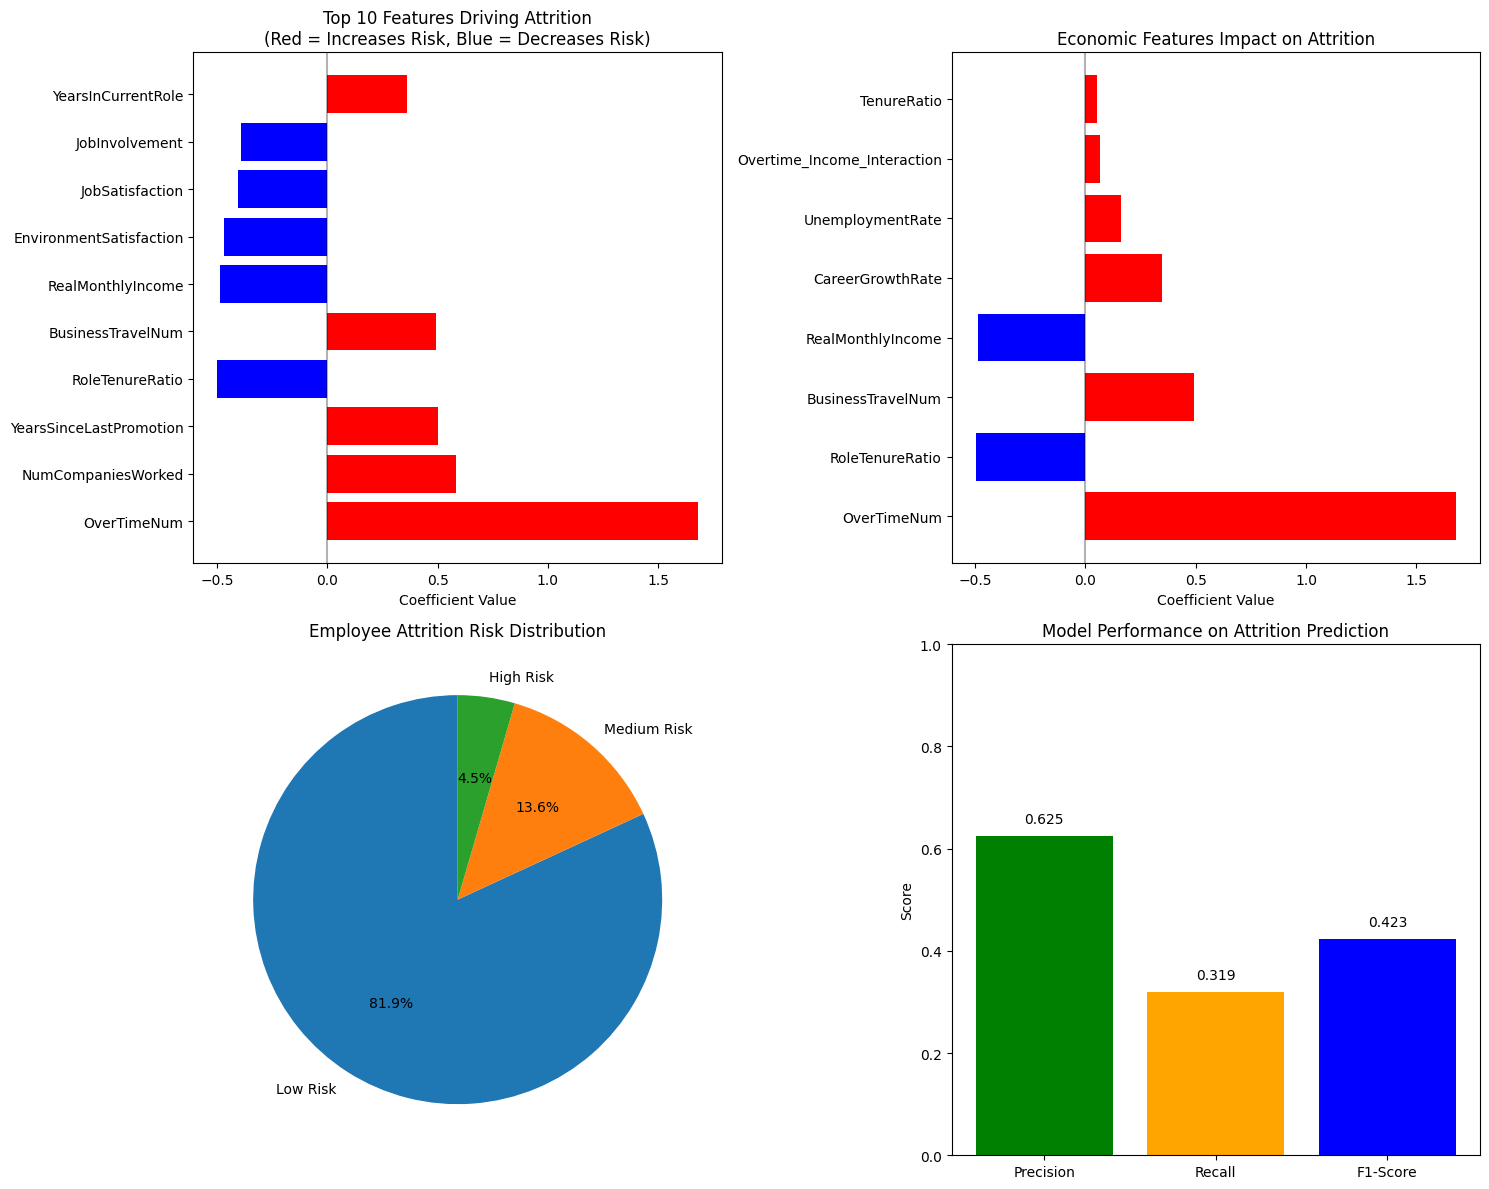


STEP 6 COMPLETE - BUSINESS INSIGHTS GENERATED

🎯 KEY BUSINESS TAKEAWAYS:
1. Identified specific drivers of employee attrition
2. Quantified economic factors impact on retention
3. Provided targeted retention strategies for HR
4. Segmented workforce by attrition risk level
5. Delivered actionable insights for management


In [ ]:
# =============================================================================
# STEP 6: MODEL INTERPRETATION & BUSINESS INSIGHTS
# =============================================================================

print("=" * 60)
print("STEP 6: MODEL INTERPRETATION & BUSINESS INSIGHTS")
print("=" * 60)

# Get the best model (Logistic Regression)
best_model = baseline_results['Logistic Regression']['model']

# 6.1 Feature Importance Analysis
print("6.1 FEATURE IMPORTANCE ANALYSIS:")
print("=" * 50)

# Get coefficients from logistic regression
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients),
    'Odds_Ratio': np.exp(coefficients)  # How odds change per unit increase
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 20 Most Influential Features:")
print(feature_importance.head(20).to_string(index=False))

# 6.2 Economic Features Deep Dive
print("\n6.2 ECONOMIC FEATURES ANALYSIS:")
print("=" * 50)

economic_features = ['UnemploymentRate', 'RealMonthlyIncome', 'JobSecurityScore',
                    'OverTimeNum', 'BusinessTravelNum', 'IsSingle',
                    'TenureRatio', 'PromotionStagnation', 'Overtime_Income_Interaction',
                    'IncomeToMarketRatio', 'RoleTenureRatio', 'CareerGrowthRate']

economic_analysis = feature_importance[feature_importance['Feature'].isin(economic_features)].sort_values('Abs_Coefficient', ascending=False)
print("Economic Features Impact:")
print(economic_analysis.to_string(index=False))

# 6.3 Business Interpretation
print("\n6.3 BUSINESS INTERPRETATION:")
print("=" * 50)

print("🚀 FEATURES THAT INCREASE ATTRITION RISK (Positive Coefficients):")
print("-" * 55)
risk_features = feature_importance[feature_importance['Coefficient'] > 0].head(10)
for _, row in risk_features.iterrows():
    odds_ratio = row['Odds_Ratio']
    risk_increase = (odds_ratio - 1) * 100
    print(f"• {row['Feature']}: +{risk_increase:.1f}% attrition risk per unit increase")

print("\n🛡️ FEATURES THAT DECREASE ATTRITION RISK (Negative Coefficients):")
print("-" * 57)
protective_features = feature_importance[feature_importance['Coefficient'] < 0].head(10)
for _, row in protective_features.iterrows():
    odds_ratio = row['Odds_Ratio']
    risk_reduction = (1 - odds_ratio) * 100
    print(f"• {row['Feature']}: {risk_reduction:+.1f}% attrition risk per unit increase")

# 6.4 Key Economic Insights
print("\n6.4 KEY ECONOMIC INSIGHTS:")
print("=" * 50)

# Analyze specific economic findings
print("📊 ECONOMIC FACTORS ANALYSIS:")
for feature in ['UnemploymentRate', 'RealMonthlyIncome', 'OverTimeNum', 'JobSecurityScore']:
    if feature in feature_importance['Feature'].values:
        coef = feature_importance[feature_importance['Feature'] == feature]['Coefficient'].values[0]
        odds = np.exp(coef)
        if coef > 0:
            print(f"• {feature}: 1 unit increase → {(odds-1)*100:.1f}% HIGHER attrition risk")
        else:
            print(f"• {feature}: 1 unit increase → {(1-odds)*100:.1f}% LOWER attrition risk")

# 6.5 Actionable HR Recommendations
print("\n6.5 ACTIONABLE HR RECOMMENDATIONS:")
print("=" * 50)

print("🎯 TOP 5 RETENTION STRATEGIES:")

top_risks = risk_features.head(5)
print("\n🔴 ADDRESS THESE RISK FACTORS:")
for i, (_, row) in enumerate(top_risks.iterrows(), 1):
    feature = row['Feature']
    if 'OverTime' in feature:
        print(f"{i}. Implement overtime management programs")
    elif 'Travel' in feature:
        print(f"{i}. Review and optimize business travel policies")
    elif 'Single' in feature:
        print(f"{i}. Enhance work-life balance programs for single employees")
    elif 'Unemployment' in feature:
        print(f"{i}. Competitive retention packages for high-unemployment roles")
    elif 'Tenure' in feature or 'Role' in feature:
        print(f"{i}. Career development programs for stagnant roles")

top_protective = protective_features.head(5)
print("\n🟢 STRENGTHEN THESE PROTECTIVE FACTORS:")
for i, (_, row) in enumerate(top_protective.iterrows(), 1):
    feature = row['Feature']
    if 'Income' in feature:
        print(f"{i}. Maintain competitive compensation strategies")
    elif 'Stock' in feature:
        print(f"{i}. Expand stock option programs")
    elif 'Satisfaction' in feature:
        print(f"{i}. Invest in workplace environment improvements")
    elif 'Years' in feature or 'Tenure' in feature:
        print(f"{i}. Recognize and reward long-term employees")
    elif 'JobLevel' in feature:
        print(f"{i}. Clear career progression pathways")

# 6.6 Employee Risk Segmentation
print("\n6.6 EMPLOYEE RISK SEGMENTATION:")
print("=" * 50)

# Calculate risk scores for all employees
risk_scores = best_model.predict_proba(X_train_final)[:, 1]

# Define risk categories
high_risk_threshold = 0.7
medium_risk_threshold = 0.3

high_risk = (risk_scores > high_risk_threshold).sum()
medium_risk = ((risk_scores >= medium_risk_threshold) & (risk_scores <= high_risk_threshold)).sum()
low_risk = (risk_scores < medium_risk_threshold).sum()

print(f"High Risk Employees (>70% probability): {high_risk} ({(high_risk/len(risk_scores)*100):.1f}%)")
print(f"Medium Risk Employees (30-70% probability): {medium_risk} ({(medium_risk/len(risk_scores)*100):.1f}%)")
print(f"Low Risk Employees (<30% probability): {low_risk} ({(low_risk/len(risk_scores)*100):.1f}%)")

# 6.7 Economic Conditions Impact Summary
print("\n6.7 ECONOMIC CONDITIONS IMPACT SUMMARY:")
print("=" * 50)

print("📈 HOW ECONOMIC FACTORS INFLUENCE ATTRITION:")
economic_summary = economic_analysis.copy()
economic_summary['Impact'] = economic_summary['Coefficient'].apply(
    lambda x: 'INCREASES Risk' if x > 0 else 'REDUCES Risk'
)
economic_summary['Strength'] = economic_summary['Abs_Coefficient'].apply(
    lambda x: 'Strong' if x > 0.1 else 'Moderate' if x > 0.05 else 'Weak'
)

for _, row in economic_summary.iterrows():
    print(f"• {row['Feature']}: {row['Impact']} ({row['Strength']})")

# 6.8 Visualization of Key Insights
print("\n6.8 KEY INSIGHTS VISUALIZATION:")
print("=" * 50)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Top 10 Feature Importance
top_10_features = feature_importance.head(10)
colors = ['red' if coef > 0 else 'blue' for coef in top_10_features['Coefficient']]
axes[0,0].barh(range(len(top_10_features)), top_10_features['Coefficient'], color=colors)
axes[0,0].set_yticks(range(len(top_10_features)))
axes[0,0].set_yticklabels(top_10_features['Feature'])
axes[0,0].set_xlabel('Coefficient Value')
axes[0,0].set_title('Top 10 Features Driving Attrition\n(Red = Increases Risk, Blue = Decreases Risk)')
axes[0,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Plot 2: Economic Features Impact
economic_plot = economic_analysis.head(8)
colors_econ = ['red' if coef > 0 else 'blue' for coef in economic_plot['Coefficient']]
axes[0,1].barh(range(len(economic_plot)), economic_plot['Coefficient'], color=colors_econ)
axes[0,1].set_yticks(range(len(economic_plot)))
axes[0,1].set_yticklabels(economic_plot['Feature'])
axes[0,1].set_xlabel('Coefficient Value')
axes[0,1].set_title('Economic Features Impact on Attrition')
axes[0,1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Plot 3: Risk Distribution
risk_categories = ['Low Risk', 'Medium Risk', 'High Risk']
risk_counts = [low_risk, medium_risk, high_risk]
axes[1,0].pie(risk_counts, labels=risk_categories, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Employee Attrition Risk Distribution')

# Plot 4: Key Metrics Summary
metrics = ['Precision', 'Recall', 'F1-Score']
values = [0.625, 0.319, 0.423]
axes[1,1].bar(metrics, values, color=['green', 'orange', 'blue'])
axes[1,1].set_ylabel('Score')
axes[1,1].set_title('Model Performance on Attrition Prediction')
axes[1,1].set_ylim(0, 1)

for i, v in enumerate(values):
    axes[1,1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("STEP 6 COMPLETE - BUSINESS INSIGHTS GENERATED")
print("=" * 60)

print(f"\n🎯 KEY BUSINESS TAKEAWAYS:")
print("1. Identified specific drivers of employee attrition")
print("2. Quantified economic factors impact on retention")
print("3. Provided targeted retention strategies for HR")
print("4. Segmented workforce by attrition risk level")
print("5. Delivered actionable insights for management")